# lesson-2

## Программа с урока:

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 42 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 16s


In [11]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
common_corpus[10]

[(81, 1),
 (96, 1),
 (101, 1),
 (103, 1),
 (108, 2),
 (123, 1),
 (136, 1),
 (153, 1),
 (155, 1),
 (165, 1),
 (174, 1),
 (215, 1),
 (225, 1),
 (246, 1),
 (251, 1),
 (280, 2),
 (404, 1),
 (405, 1),
 (406, 2),
 (407, 1),
 (408, 1),
 (409, 1),
 (410, 1),
 (411, 1),
 (412, 1),
 (413, 1),
 (414, 1),
 (415, 1),
 (416, 1),
 (417, 1)]

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
from gensim.models import LdaModel

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 56.2 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.2492342),
 (2, 0.27514014),
 (9, 0.03244715),
 (23, 0.3801044),
 (24, 0.045181513)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: это год который мочь весь россия всё
topic_1: ребёнок фонд женщина который человек риск закон
topic_2: это год который исследование человек весь свой
topic_3: ракета произойти тело который сша это результат
topic_4: год это который россия российский страна мочь
topic_5: грузия ухо ск повторяться добраться выложить согласовывать
topic_6: азия пилотировать дания лёд включение понятие китайский
topic_7: подразделение японский сопровождать артист зуб рисунок уильям
topic_8: расчёт вирус фрагмент методика автор резерв акционер
topic_9: квартира рак египет виза туризм билет год
topic_10: операция армия пациент поверхность пенсия сша год
topic_11: год суд млн журнал который nn человек
topic_12: писать налог предупредить армения вдвое энергия подсчитать
topic_13: газ температура это научный мочь рейс километр
topic_14: рубль год млрд размер доллар это ставка
topic_15: восток дыра бизнесмен бомба ирак иракский катастрофический
topic_16: который nn сотрудник источник человек это экспери

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.35236,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.022170,0.0,0.065992,0.032269
1,4896,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.587275,0.0,0.000000,0.0,0.0,0.000000,0.0,0.389711,0.000000
2,4897,0.249280,0.0,0.275077,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.380103,0.045198
3,4898,0.065331,0.0,0.470085,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.359889,0.0,0.094765,0.000000
4,4899,0.423539,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.059584,0.0,0.381215,0.0,0.0,0.000000,0.0,0.112168,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.21346606, 0.        , 0.        , 0.11086068, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09616334,
       0.        , 0.27195498, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02950566, 0.        ,
       0.        , 0.        , 0.26651964, 0.        , 0.        ])

In [25]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [26]:
get_user_embedding(user_articles_list)

array([0.20670264, 0.07154078, 0.0285239 , 0.01716507, 0.12312233,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03075675, 0.10645883, 0.        , 0.00210344, 0.02918457,
       0.00872643, 0.05971461, 0.        , 0.02683216, 0.01165702,
       0.        , 0.19005039, 0.07166076, 0.00377879, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.111418,0.023100,0.034056,0.056479,0.084815,0.000000,0.008173,0.0,0.000000,...,0.002346,0.088528,0.065967,0.023091,0.027427,0.0,0.137445,0.083877,0.043730,0.0
1,u108690,0.158370,0.039712,0.060107,0.074739,0.163026,0.000000,0.000000,0.0,0.000000,...,0.000000,0.105481,0.006497,0.017655,0.023197,0.0,0.129528,0.120114,0.013733,0.0
2,u108339,0.035858,0.020468,0.041537,0.085782,0.130637,0.001871,0.000000,0.0,0.001697,...,0.011631,0.125270,0.013136,0.047307,0.003085,0.0,0.174175,0.113532,0.010886,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [28]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.111418,0.023100,0.034056,0.056479,0.084815,0.000000,0.008173,0.0,0.000000,...,0.088528,0.065967,0.023091,0.027427,0.0,0.137445,0.083877,0.043730,0.0,0
1,u108690,0.158370,0.039712,0.060107,0.074739,0.163026,0.000000,0.000000,0.0,0.000000,...,0.105481,0.006497,0.017655,0.023197,0.0,0.129528,0.120114,0.013733,0.0,1
2,u108339,0.035858,0.020468,0.041537,0.085782,0.130637,0.001871,0.000000,0.0,0.001697,...,0.125270,0.013136,0.047307,0.003085,0.0,0.174175,0.113532,0.010886,0.0,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [32]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21748704, 0.06799009, 0.27148609, 0.07558217, 0.0484178 ,
       0.06222456, 0.11807169, 0.04127462, 0.09679462, 0.13962249])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [35]:
import itertools

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f_score = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f_score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
thresholds_mean = thresholds[ix]
f_score_mean = f_score[ix]
precision_mean = precision[ix]
recall_mean = recall[ix]

Best Threshold=0.252866, F-Score=0.581, Precision=0.566, Recall=0.596


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1643  112]
 [ 100  145]]


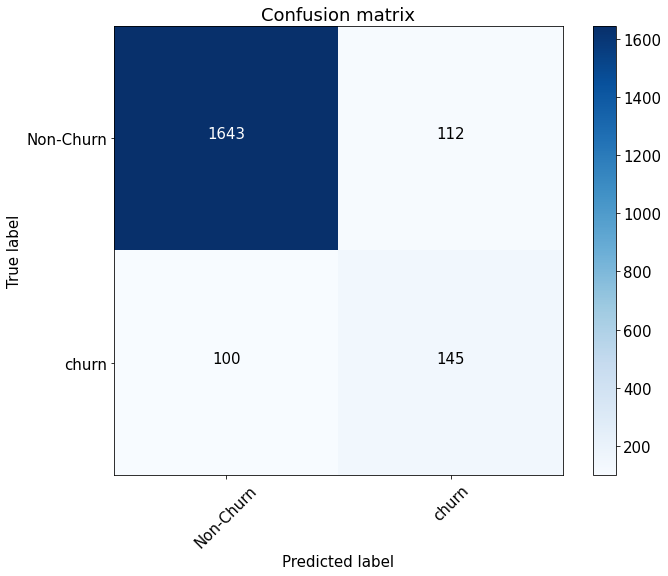

In [38]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [39]:
roc_auc_mean = roc_auc_score(y_test, preds)
roc_auc_mean

0.9156788185359614

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

## 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

## 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [40]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [42]:
X = pd.merge(user_embeddings, target, 'left')

In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [44]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
preds = logreg.predict_proba(X_test)[:, 1]

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f_score = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f_score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
thresholds_median = thresholds[ix]
f_score_median = f_score[ix]
precision_median = precision[ix]
recall_median = recall[ix]

Best Threshold=0.229417, F-Score=0.688, Precision=0.593, Recall=0.820


In [47]:
roc_auc_median = roc_auc_score(y_test, preds)
roc_auc_median

0.9519925577068434

## 3. Повторить п.2, но используя уже не медиану, а max

In [48]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [49]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [50]:
X = pd.merge(user_embeddings, target, 'left')

In [51]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [52]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [53]:
preds = logreg.predict_proba(X_test)[:, 1]

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f_score = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f_score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
thresholds_max = thresholds[ix]
f_score_max = f_score[ix]
precision_max = precision[ix]
recall_max = recall[ix]

Best Threshold=0.328819, F-Score=0.807, Precision=0.779, Recall=0.837


In [55]:
roc_auc_max = roc_auc_score(y_test, preds)
roc_auc_max

0.9763474620617477

## 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer

In [57]:
doc_id = topic_matrix['doc_id']

In [58]:
idf_transformer = TfidfTransformer()

In [59]:
idf_transformer.fit(topic_matrix.drop(columns='doc_id').transpose())

TfidfTransformer()

In [60]:
idf = idf_transformer.idf_
idf

array([2.46633707, 3.15948425, 2.46633707, ..., 2.06087196, 2.31218639,
       2.64865863])

In [61]:
dict_idf = dict(zip(doc_id, idf))
dict_idf[10]

2.466337068793427

In [62]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] * dict_idf[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [63]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [64]:
X = pd.merge(user_embeddings, target, 'left')

In [65]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [66]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [67]:
preds = logreg.predict_proba(X_test)[:, 1]

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f_score = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        f_score[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
thresholds_idf_mean = thresholds[ix]
f_score_idf_mean = f_score[ix]
precision_idf_mean = precision[ix]
recall_idf_mean = recall[ix]

Best Threshold=0.364024, F-Score=0.877, Precision=0.894, Recall=0.861


In [69]:
roc_auc_idf_mean = roc_auc_score(y_test, preds)
roc_auc_idf_mean

0.9888249316820745

## 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [70]:
united_table = pd.DataFrame({'agg_embedding': ['mean', 'median', 'max', 'idf_mean'], 
                             'roc_auc': [roc_auc_mean, roc_auc_median, roc_auc_max, roc_auc_idf_mean], 
                             'precision': [precision_mean, precision_median, precision_max, precision_idf_mean], 
                             'recall': [recall_mean, recall_median, recall_max, recall_idf_mean],
                             'f_score': [f_score_mean, f_score_median, f_score_max, f_score_idf_mean]})
united_table

,agg_embedding,roc_auc,precision,recall,f_score
0,mean,0.915679,0.565891,0.595918,0.580517
1,median,0.951993,0.592920,0.820408,0.688356
2,max,0.976347,0.779468,0.836735,0.807087
3,idf_mean,0.988825,0.894068,0.861224,0.877339


Вывод: для нас важны редкие значения, они наиболее информативны.

Поэотму:

mean_agg_embedding хуже всех, так как сглаживает данные, что они становятся менее информативны,

median_agg_embedding не учитывает редкие данные,

max_agg_embedding учитывает редкие значения, но грубо, теряя другую информацию,

idf_agg_embedding лучше всех, так как он использует точные коэффициенты для значений, в зависимости от их редкости.